# Method 6 - Best Ideas High Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] < qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

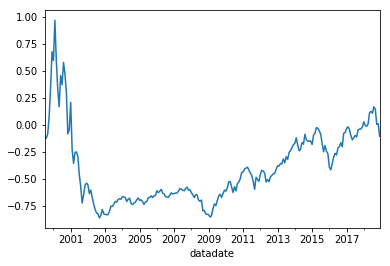

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.679248
2000-12-31   -0.432548
2001-12-31   -0.519165
2002-12-31   -0.624141
2003-12-31    0.791037
2004-12-31    0.040424
2005-12-31    0.066196
2006-12-31    0.042658
2007-12-31    0.113088
2008-12-31   -0.572519
2009-12-31    1.317075
2010-12-31    0.415653
2011-12-31   -0.149676
2012-12-31    0.241271
2013-12-31    0.388095
2014-12-31    0.040519
2015-12-31   -0.138686
2016-12-31    0.268060
2017-12-31    0.057569
2018-12-31   -0.088536
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     207.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.99e-75
Time:                        15:06:08   Log-Likelihood:                 359.20
No. Observations:                 234   AIC:                            -708.4
Df Residuals:                     229   BIC:                            -691.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.348      0.179      -0.002       0.012
mktrf          1.3683      0.098     13.922      0.000       1.175       1.562
me             0.4174      0.114      3.651      0.000       0.192       0.643
ia            -0.6745      0.174     -3.882      0.000      -1.017      -0.332
roe           -1.2857      0.149     -8.644      0.000      -1.579      -0.993
==============================================================================
Omnibus:                      125.972   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1762.864
Skew:                           1.743   Prob(JB):                         0.00
Kurtosis:                      15.986   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     71.82
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.44e-39
Time:                        15:06:08   Log-Likelihood:                 359.20
No. Observations:                 234   AIC:                            -708.4
Df Residuals:                     229   BIC:                            -691.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.389      0.165      -0.002       0.012
mktrf          1.3683      0.194      7.071      0.000       0.989       1.748
me             0.4174      0.146      2.863      0.004       0.132       0.703
ia            -0.6745      0.253     -2.662      0.008      -1.171      -0.178
roe           -1.2857      0.244     -5.259      0.000      -1.765      -0.807
==============================================================================
Omnibus:                      125.972   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1762.864
Skew:                           1.743   Prob(JB):                         0.00
Kurtosis:                      15.986   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     91.75
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.95e-46
Time:                        15:06:08   Log-Likelihood:                 359.20
No. Observations:                 234   AIC:                            -708.4
Df Residuals:                     229   BIC:                            -691.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.323      0.186      -0.002       0.012
mktrf          1.3683      0.200      6.858      0.000       0.977       1.759
me             0.4174      0.156      2.674      0.007       0.111       0.723
ia            -0.6745      0.242     -2.783      0.005      -1.149      -0.199
roe           -1.2857      0.266     -4.834      0.000      -1.807      -0.764
==============================================================================
Omnibus:                      125.972   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1762.864
Skew:                           1.743   Prob(JB):                         0.00
Kurtosis:                      15.986   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     171.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.09e-75
Time:                        15:06:08   Log-Likelihood:                 362.56
No. Observations:                 234   AIC:                            -713.1
Df Residuals:                     228   BIC:                            -692.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.004      1.205      0.229      -0.003       0.011
mktrf          1.4892      0.097     15.307      0.000       1.297       1.681
smb            0.4120      0.128      3.210      0.002       0.159       0.665
hml           -0.2416      0.151     -1.596      0.112      -0.540       0.057
rmw           -1.2764      0.171     -7.458      0.000      -1.614      -0.939
cma           -0.1650      0.218     -0.759      0.449      -0.594       0.264
==============================================================================
Omnibus:                      119.481   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1085.403
Skew:                           1.783   Prob(JB):                    2.03e-236
Kurtosis:                      12.930   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     79.46
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.34e-48
Time:                        15:06:08   Log-Likelihood:                 362.56
No. Observations:                 234   AIC:                            -713.1
Df Residuals:                     228   BIC:                            -692.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.003      1.426      0.154      -0.002       0.010
mktrf          1.4892      0.123     12.146      0.000       1.249       1.729
smb            0.4120      0.132      3.117      0.002       0.153       0.671
hml           -0.2416      0.255     -0.947      0.343      -0.741       0.258
rmw           -1.2764      0.227     -5.622      0.000      -1.721      -0.831
cma           -0.1650      0.353     -0.468      0.640      -0.856       0.526
==============================================================================
Omnibus:                      119.481   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1085.403
Skew:                           1.783   Prob(JB):                    2.03e-236
Kurtosis:                      12.930   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     83.91
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.02e-49
Time:                        15:06:08   Log-Likelihood:                 362.56
No. Observations:                 234   AIC:                            -713.1
Df Residuals:                     228   BIC:                            -692.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.003      1.338      0.181      -0.002       0.011
mktrf          1.4892      0.117     12.729      0.000       1.260       1.718
smb            0.4120      0.126      3.274      0.001       0.165       0.659
hml           -0.2416      0.213     -1.135      0.256      -0.659       0.175
rmw           -1.2764      0.248     -5.154      0.000      -1.762      -0.791
cma           -0.1650      0.310     -0.532      0.595      -0.773       0.443
==============================================================================
Omnibus:                      119.481   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1085.403
Skew:                           1.783   Prob(JB):                    2.03e-236
Kurtosis:                      12.930   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     203.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.03e-74
Time:                        15:06:08   Log-Likelihood:                 357.70
No. Observations:                 234   AIC:                            -705.4
Df Residuals:                     229   BIC:                            -688.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.701e-05      0.004      0.008      0.994      -0.007       0.007
mktrf          1.6047      0.091     17.619      0.000       1.425       1.784
smb            1.0040      0.114      8.832      0.000       0.780       1.228
hml           -0.6882      0.113     -6.094      0.000      -0.911      -0.466
umd           -0.4743      0.074     -6.401      0.000      -0.620      -0.328
==============================================================================
Omnibus:                       97.729   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              780.890
Skew:                           1.414   Prob(JB):                    2.70e-170
Kurtosis:                      11.491   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     84.99
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.86e-44
Time:                        15:06:08   Log-Likelihood:                 357.70
No. Observations:                 234   AIC:                            -705.4
Df Residuals:                     229   BIC:                            -688.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.701e-05      0.003      0.009      0.993      -0.006       0.006
mktrf          1.6047      0.145     11.099      0.000       1.321       1.888
smb            1.0040      0.104      9.621      0.000       0.800       1.209
hml           -0.6882      0.188     -3.666      0.000      -1.056      -0.320
umd           -0.4743      0.122     -3.894      0.000      -0.713      -0.236
==============================================================================
Omnibus:                       97.729   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              780.890
Skew:                           1.414   Prob(JB):                    2.70e-170
Kurtosis:                      11.491   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     86.90
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.41e-45
Time:                        15:06:08   Log-Likelihood:                 357.70
No. Observations:                 234   AIC:                            -705.4
Df Residuals:                     229   BIC:                            -688.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.701e-05      0.003      0.009      0.993      -0.006       0.006
mktrf          1.6047      0.146     11.011      0.000       1.319       1.890
smb            1.0040      0.091     11.086      0.000       0.827       1.182
hml           -0.6882      0.174     -3.957      0.000      -1.029      -0.347
umd           -0.4743      0.127     -3.742      0.000      -0.723      -0.226
==============================================================================
Omnibus:                       97.729   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              780.890
Skew:                           1.414   Prob(JB):                    2.70e-170
Kurtosis:                      11.491   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     100.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.41e-36
Time:                        15:06:08   Log-Likelihood:                 158.01
No. Observations:                 120   AIC:                            -306.0
Df Residuals:                     115   BIC:                            -292.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.006      1.386      0.168      -0.004       0.021
mktrf          1.2274      0.171      7.189      0.000       0.889       1.566
me             0.3155      0.169      1.871      0.064      -0.019       0.650
ia            -0.8451      0.264     -3.200      0.002      -1.368      -0.322
roe           -1.4754      0.234     -6.312      0.000      -1.938      -1.012
==============================================================================
Omnibus:                       56.055   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              339.279
Skew:                           1.421   Prob(JB):                     2.12e-74
Kurtosis:                      10.732   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     61.21
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.31e-27
Time:                        15:06:08   Log-Likelihood:                 158.01
No. Observations:                 120   AIC:                            -306.0
Df Residuals:                     115   BIC:                            -292.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.005      1.645      0.100      -0.002       0.019
mktrf          1.2274      0.322      3.814      0.000       0.597       1.858
me             0.3155      0.200      1.574      0.115      -0.077       0.708
ia            -0.8451      0.360     -2.346      0.019      -1.551      -0.139
roe           -1.4754      0.357     -4.131      0.000      -2.175      -0.775
==============================================================================
Omnibus:                       56.055   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              339.279
Skew:                           1.421   Prob(JB):                     2.12e-74
Kurtosis:                      10.732   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     126.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.96e-41
Time:                        15:06:08   Log-Likelihood:                 158.01
No. Observations:                 120   AIC:                            -306.0
Df Residuals:                     115   BIC:                            -292.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.005      1.647      0.100      -0.002       0.019
mktrf          1.2274      0.339      3.617      0.000       0.562       1.893
me             0.3155      0.213      1.479      0.139      -0.102       0.733
ia            -0.8451      0.334     -2.527      0.011      -1.501      -0.190
roe           -1.4754      0.396     -3.727      0.000      -2.251      -0.700
==============================================================================
Omnibus:                       56.055   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              339.279
Skew:                           1.421   Prob(JB):                     2.12e-74
Kurtosis:                      10.732   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     84.16
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.28e-36
Time:                        15:06:08   Log-Likelihood:                 160.62
No. Observations:                 120   AIC:                            -309.2
Df Residuals:                     114   BIC:                            -292.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.006      1.494      0.138      -0.003       0.022
mktrf          1.5768      0.177      8.912      0.000       1.226       1.927
smb            0.3810      0.200      1.901      0.060      -0.016       0.778
hml           -0.5410      0.246     -2.203      0.030      -1.027      -0.054
rmw           -1.0623      0.290     -3.669      0.000      -1.636      -0.489
cma           -0.1293      0.317     -0.408      0.684      -0.758       0.499
==============================================================================
Omnibus:                       61.647   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              284.816
Skew:                           1.735   Prob(JB):                     1.42e-62
Kurtosis:                       9.702   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     46.67
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.91e-26
Time:                        15:06:08   Log-Likelihood:                 160.62
No. Observations:                 120   AIC:                            -309.2
Df Residuals:                     114   BIC:                            -292.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.004      2.315      0.021       0.001       0.018
mktrf          1.5768      0.212      7.421      0.000       1.160       1.993
smb            0.3810      0.194      1.960      0.050    3.63e-05       0.762
hml           -0.5410      0.247     -2.193      0.028      -1.024      -0.058
rmw           -1.0623      0.304     -3.500      0.000      -1.657      -0.467
cma           -0.1293      0.406     -0.319      0.750      -0.924       0.665
==============================================================================
Omnibus:                       61.647   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              284.816
Skew:                           1.735   Prob(JB):                     1.42e-62
Kurtosis:                       9.702   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     63.60
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.24e-31
Time:                        15:06:08   Log-Likelihood:                 160.62
No. Observations:                 120   AIC:                            -309.2
Df Residuals:                     114   BIC:                            -292.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.004      2.352      0.019       0.002       0.017
mktrf          1.5768      0.189      8.341      0.000       1.206       1.947
smb            0.3810      0.178      2.135      0.033       0.031       0.731
hml           -0.5410      0.206     -2.632      0.008      -0.944      -0.138
rmw           -1.0623      0.334     -3.176      0.001      -1.718      -0.407
cma           -0.1293      0.339     -0.381      0.703      -0.794       0.536
==============================================================================
Omnibus:                       61.647   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              284.816
Skew:                           1.735   Prob(JB):                     1.42e-62
Kurtosis:                       9.702   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     113.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.23e-39
Time:                        15:06:08   Log-Likelihood:                 163.87
No. Observations:                 120   AIC:                            -317.7
Df Residuals:                     115   BIC:                            -303.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.006      0.774      0.440      -0.007       0.016
mktrf          1.6522      0.143     11.534      0.000       1.368       1.936
smb            0.9432      0.163      5.783      0.000       0.620       1.266
hml           -0.9584      0.163     -5.867      0.000      -1.282      -0.635
umd           -0.4615      0.101     -4.582      0.000      -0.661      -0.262
==============================================================================
Omnibus:                       57.483   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              302.775
Skew:                           1.529   Prob(JB):                     1.79e-66
Kurtosis:                      10.155   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     103.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.74e-37
Time:                        15:06:08   Log-Likelihood:                 163.87
No. Observations:                 120   AIC:                            -317.7
Df Residuals:                     115   BIC:                            -303.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.005      1.000      0.318      -0.004       0.014
mktrf          1.6522      0.217      7.629      0.000       1.228       2.077
smb            0.9432      0.136      6.949      0.000       0.677       1.209
hml           -0.9584      0.243     -3.940      0.000      -1.435      -0.482
umd           -0.4615      0.130     -3.539      0.000      -0.717      -0.206
==============================================================================
Omnibus:                       57.483   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              302.775
Skew:                           1.529   Prob(JB):                     1.79e-66
Kurtosis:                      10.155   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     212.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.31e-52
Time:                        15:06:08   Log-Likelihood:                 163.87
No. Observations:                 120   AIC:                            -317.7
Df Residuals:                     115   BIC:                            -303.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.005      0.995      0.320      -0.004       0.014
mktrf          1.6522      0.224      7.383      0.000       1.214       2.091
smb            0.9432      0.119      7.904      0.000       0.709       1.177
hml           -0.9584      0.215     -4.454      0.000      -1.380      -0.537
umd           -0.4615      0.136     -3.404      0.001      -0.727      -0.196
==============================================================================
Omnibus:                       57.483   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              302.775
Skew:                           1.529   Prob(JB):                     1.79e-66
Kurtosis:                      10.155   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     137.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.33e-41
Time:                        15:06:08   Log-Likelihood:                 234.57
No. Observations:                 114   AIC:                            -459.1
Df Residuals:                     109   BIC:                            -445.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.159      0.874      -0.006       0.007
mktrf          1.4638      0.093     15.749      0.000       1.280       1.648
me             0.6184      0.144      4.309      0.000       0.334       0.903
ia            -0.1761      0.199     -0.885      0.378      -0.571       0.218
roe           -0.7939      0.175     -4.539      0.000      -1.141      -0.447
==============================================================================
Omnibus:                        3.889   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                4.609
Skew:                          -0.067   Prob(JB):                       0.0998
Kurtosis:                       3.976   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     176.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.09e-46
Time:                        15:06:08   Log-Likelihood:                 234.57
No. Observations:                 114   AIC:                            -459.1
Df Residuals:                     109   BIC:                            -445.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.189      0.850      -0.005       0.006
mktrf          1.4638      0.118     12.453      0.000       1.233       1.694
me             0.6184      0.166      3.733      0.000       0.294       0.943
ia            -0.1761      0.257     -0.684      0.494      -0.680       0.328
roe           -0.7939      0.172     -4.620      0.000      -1.131      -0.457
==============================================================================
Omnibus:                        3.889   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                4.609
Skew:                          -0.067   Prob(JB):                       0.0998
Kurtosis:                       3.976   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     254.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.64e-54
Time:                        15:06:08   Log-Likelihood:                 234.57
No. Observations:                 114   AIC:                            -459.1
Df Residuals:                     109   BIC:                            -445.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.219      0.827      -0.004       0.005
mktrf          1.4638      0.122     11.971      0.000       1.224       1.703
me             0.6184      0.185      3.337      0.001       0.255       0.982
ia            -0.1761      0.295     -0.598      0.550      -0.754       0.401
roe           -0.7939      0.177     -4.492      0.000      -1.140      -0.448
==============================================================================
Omnibus:                        3.889   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                4.609
Skew:                          -0.067   Prob(JB):                       0.0998
Kurtosis:                       3.976   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     113.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.34e-41
Time:                        15:06:08   Log-Likelihood:                 236.65
No. Observations:                 114   AIC:                            -461.3
Df Residuals:                     108   BIC:                            -444.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.137      0.891      -0.007       0.006
mktrf          1.4547      0.087     16.637      0.000       1.281       1.628
smb            0.4698      0.142      3.310      0.001       0.188       0.751
hml            0.2658      0.181      1.468      0.145      -0.093       0.625
rmw           -1.1784      0.222     -5.316      0.000      -1.618      -0.739
cma           -0.2264      0.281     -0.805      0.423      -0.784       0.331
==============================================================================
Omnibus:                        8.167   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                9.176
Skew:                          -0.449   Prob(JB):                       0.0102
Kurtosis:                       4.061   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     114.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.86e-41
Time:                        15:06:08   Log-Likelihood:                 236.65
No. Observations:                 114   AIC:                            -461.3
Df Residuals:                     108   BIC:                            -444.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.139      0.889      -0.006       0.006
mktrf          1.4547      0.089     16.267      0.000       1.279       1.630
smb            0.4698      0.149      3.151      0.002       0.178       0.762
hml            0.2658      0.187      1.425      0.154      -0.100       0.631
rmw           -1.1784      0.214     -5.514      0.000      -1.597      -0.760
cma           -0.2264      0.312     -0.725      0.468      -0.838       0.385
==============================================================================
Omnibus:                        8.167   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                9.176
Skew:                          -0.449   Prob(JB):                       0.0102
Kurtosis:                       4.061   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     174.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.52e-50
Time:                        15:06:08   Log-Likelihood:                 236.65
No. Observations:                 114   AIC:                            -461.3
Df Residuals:                     108   BIC:                            -444.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.154      0.877      -0.006       0.005
mktrf          1.4547      0.093     15.633      0.000       1.272       1.637
smb            0.4698      0.152      3.086      0.002       0.171       0.768
hml            0.2658      0.160      1.660      0.097      -0.048       0.580
rmw           -1.1784      0.190     -6.190      0.000      -1.552      -0.805
cma           -0.2264      0.343     -0.660      0.509      -0.899       0.446
==============================================================================
Omnibus:                        8.167   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                9.176
Skew:                          -0.449   Prob(JB):                       0.0102
Kurtosis:                       4.061   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     113.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.24e-38
Time:                        15:06:08   Log-Likelihood:                 225.54
No. Observations:                 114   AIC:                            -441.1
Df Residuals:                     109   BIC:                            -427.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.003     -0.598      0.551      -0.009       0.005
mktrf          1.5095      0.095     15.832      0.000       1.321       1.698
smb            0.7482      0.149      5.033      0.000       0.454       1.043
hml            0.2072      0.153      1.353      0.179      -0.096       0.511
umd           -0.2876      0.116     -2.490      0.014      -0.517      -0.059
==============================================================================
Omnibus:                        1.520   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.468   Jarque-Bera (JB):                1.187
Skew:                          -0.245   Prob(JB):                        0.552
Kurtosis:                       3.098   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     136.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.99e-41
Time:                        15:06:08   Log-Likelihood:                 225.54
No. Observations:                 114   AIC:                            -441.1
Df Residuals:                     109   BIC:                            -427.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.003     -0.688      0.491      -0.008       0.004
mktrf          1.5095      0.096     15.724      0.000       1.321       1.698
smb            0.7482      0.160      4.683      0.000       0.435       1.061
hml            0.2072      0.194      1.067      0.286      -0.173       0.588
umd           -0.2876      0.131     -2.202      0.028      -0.544      -0.032
==============================================================================
Omnibus:                        1.520   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.468   Jarque-Bera (JB):                1.187
Skew:                          -0.245   Prob(JB):                        0.552
Kurtosis:                       3.098   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     147.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.89e-43
Time:                        15:06:08   Log-Likelihood:                 225.54
No. Observations:                 114   AIC:                            -441.1
Df Residuals:                     109   BIC:                            -427.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.003     -0.787      0.431      -0.007       0.003
mktrf          1.5095      0.100     15.110      0.000       1.314       1.705
smb            0.7482      0.156      4.789      0.000       0.442       1.054
hml            0.2072      0.180      1.151      0.250      -0.146       0.560
umd           -0.2876      0.133     -2.167      0.030      -0.548      -0.027
==============================================================================
Omnibus:                        1.520   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.468   Jarque-Bera (JB):                1.187
Skew:                          -0.245   Prob(JB):                        0.552
Kurtosis:                       3.098   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""